# Poisson regression (GAM) COVID-19 Prediction

In [90]:
# Data manipulation
import numpy as np
import pandas as pd

pd.options.display.max_columns = None
pd.options.display.max_colwidth = 500

# Data viz
import matplotlib.pyplot as plt
import plotly
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns

sns.set(style="darkgrid", rc={"figure.figsize": (11.7, 8.27)})

# Modeling
from pygam import PoissonGAM, s, l, f
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit

# Other
from datetime import date, timedelta
import os
import random
import sys

# Custom module
module_path = os.path.abspath(os.path.join("../src"))
if module_path not in sys.path:
    sys.path.append(module_path)

from plotting import plot_predictions
from stem_poisson_gam import preprocess_data, StemPoissonRegressor, StemPoissonRegressorCombined
from utils import get_covid_data, get_all_covid_data

# Reload imported code
%reload_ext autoreload
%autoreload 2

# Print all output
from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = "all"

# Set seeds for reproducibility
rand_seed = 2
np.random.seed(rand_seed)
random.seed(rand_seed)

## About

The goal is to provide the most accurate forecasts for COVID-19 in Canada for new cases, deaths and recovered cases.  We'll be using an approach similar to that in the paper [Spatiotemporal Dynamics, Nowcasting and Forecasting of COVID-19 in the United States](https://arxiv.org/abs/2004.14103) which uses a generalized additive model with Poisson distribution using temporal variables (number of infected, susceptible cases at time $t-1$), spatial coordinates, time varying covariates (control measures), and constant covariates (demographic, economic, etc). For now we only use temporal variables $I_{it}$ and $Z_{it}$.

## Load data and EDA

**Given variables**
- $Y_{it}$: Current number of new case at time t for area i. Column "cases" in cases_timeseries_prov.csv
- $I_{it}$: Cumulative number of active infectious cases. Column "active_cases" in active_timeseries_prov.csv
- $C_{it}$: Cumulative confirmed cases up to time t. Column "cumulative_cases" in active_timeseries_prov.csv
- $R_{it}$: Cumulative number of infections. Column "cumulative_recovered" in active_timeseries_prov.csv

**Transformed variables**
- $N_{i}$: Population of region i. Column "population"
- $\Delta D_{it}$: New deaths/recovered cases at time t. Column "removed"
- $S_{it}$: Number of susceptible subjects at time t defined by $S_{it} = N_i - C_{it}$. Column "susceptible"
- $Z_{it}$: Log ratio of susceptible subjects $Z_{it} = log(S_{it} / N_i)$. Column "percent_susceptible" without log transform.

In [91]:
# # Read in data
active_cases_provinces = get_all_covid_data(level='prov')

# Some recovered values are negative so replace with 0 instead
active_cases_provinces = active_cases_provinces.assign(
    recovered = lambda x: x['recovered'].clip(lower=0),
    removed = lambda x: x['removed'].clip(lower=0)
)

# Get first and last day of reports
start_date = active_cases_provinces["date"].min()
end_date = active_cases_provinces["date"].max()

# Get list of provinces
provinces = active_cases_provinces["province"].unique()

# Show dataframe
active_cases_provinces.head(10)

province        date  cumulative_cases  cumulative_recovered  \
0  Alberta  2020-01-25                 0                     0   
1  Alberta  2020-01-26                 0                     0   
2  Alberta  2020-01-27                 0                     0   
3  Alberta  2020-01-28                 0                     0   
4  Alberta  2020-01-29                 0                     0   
5  Alberta  2020-01-30                 0                     0   
6  Alberta  2020-01-31                 0                     0   
7  Alberta  2020-02-01                 0                     0   
8  Alberta  2020-02-02                 0                     0   
9  Alberta  2020-02-03                 0                     0   

   cumulative_deaths  active_cases  active_cases_change  deaths  recovered  \
0                  0             0                    0       0          0   
1                  0             0                    0       0          0   
2                  0             0                    0       0          0   
3                  0             0                    0       0          0   
4                  0             0                    0       0          0   
5                  0             0                    0       0          0   
6                  0             0                    0       0          0   
7                  0             0                    0       0          0   
8                  0             0                    0       0          0   
9                  0             0                    0       0          0   

   cases  population  removed  susceptible  percent_susceptible  
0      0     4421876        0      4421876                  1.0  
1      0     4421876        0      4421876                  1.0  
2      0     4421876        0      4421876                  1.0  
3      0     4421876        0      4421876                  1.0  
4      0     4421876        0      4421876                  1.0  
5      0     4421876        0      4421876                  1.0  
6      0     4421876        0      4421876                  1.0  
7      0     4421876        0      4421876                  1.0  
8      0     4421876        0      4421876                  1.0  
9      0     4421876        0      4421876                  1.0

In [92]:
# Remove data before March 8
remove_date = date(day=8, month=3, year=2020)
active_cases_provinces = active_cases_provinces.query("date >= @remove_date")

# Ignore provinces with very little cases
provinces_ignore = ['PEI', 'New Brunswick', 'NWT', 'NL', 'Nova Scotia', 'Nunavut', 'Yukon']
active_cases_provinces = active_cases_provinces.query("province not in @provinces_ignore").reset_index(drop=True)

provinces = active_cases_provinces['province'].unique()

### Comments

- Mortality data starts March 8, 2020 so we will just ignore all dates before March 1. 

## Poisson regression

We'll be applying a similar but simpler version of the poisson regression as proposed in the paper mentioned above. Currently it only accounts for temporal effects. For a given province $i$ we have the new cases modelled as 

$$
Y_t \sim Poisson(\mu_t) \\
log(\mu_t) = \beta_{1t} + \beta_{2t}log(I_{t-1} + 1) + \alpha_tlog(S_{t-1}/N) 
$$

and the new deaths/recovered modelled as 

$$
\Delta D_t \sim Poisson({\mu_t}^D) \\
log({\mu_t}^D) = \beta_{1t}^D + \beta_{2t}^D log(I_{t-1} + 1)
$$

In [93]:
# Preprocess all province data
active_cases_provinces_preprocessed = preprocess_data(active_cases_provinces, drop_first_day=True)
X = active_cases_provinces_preprocessed
Y = active_cases_provinces_preprocessed[['province', 'date', 'cases', 'removed']]

In [94]:
# Fit model and get 3 week forecasts for each province for every province
h = 21
forecasts = pd.DataFrame()

for province in provinces:
    # Get province data
    province_data = active_cases_provinces_preprocessed.query('province == @province')
    X = province_data
    Y = province_data[['province', 'date', 'cases', 'removed']]
    
    # Fit model
    model = StemPoissonRegressor()
    model.fit(X, Y)
    
    # Get forecasts
    province_forecasts = model.forecast(h=h)
    province_forecasts = province_forecasts.merge(province_data, how='left', on=['province', 'date'])
    forecasts = pd.concat([forecasts, province_forecasts], ignore_index=True)

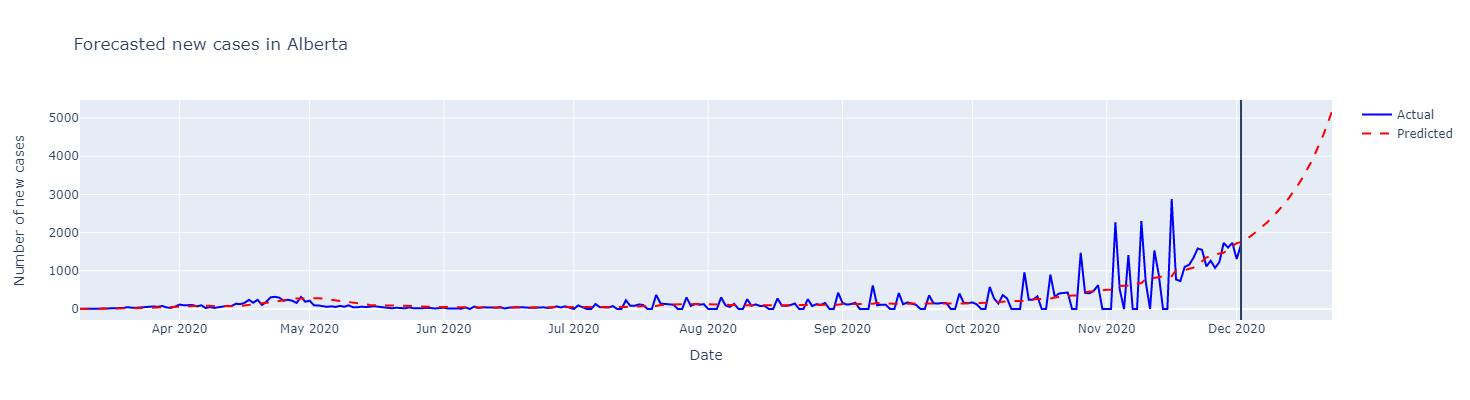

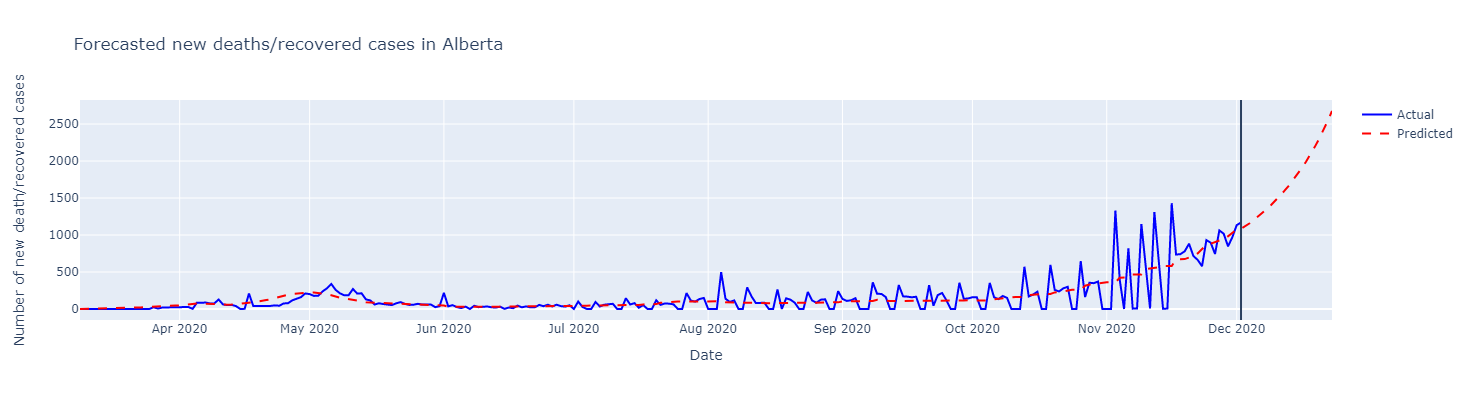

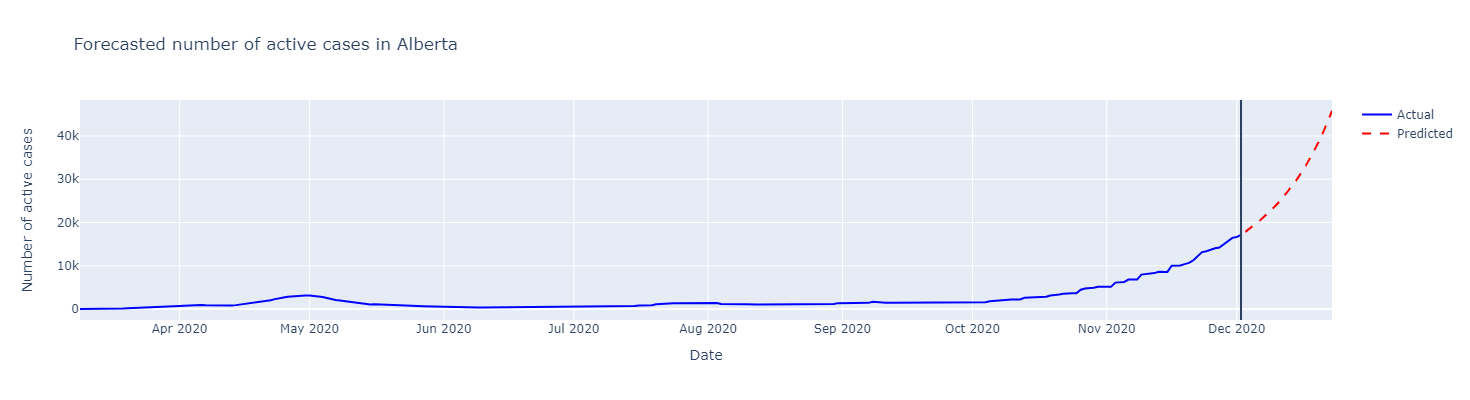

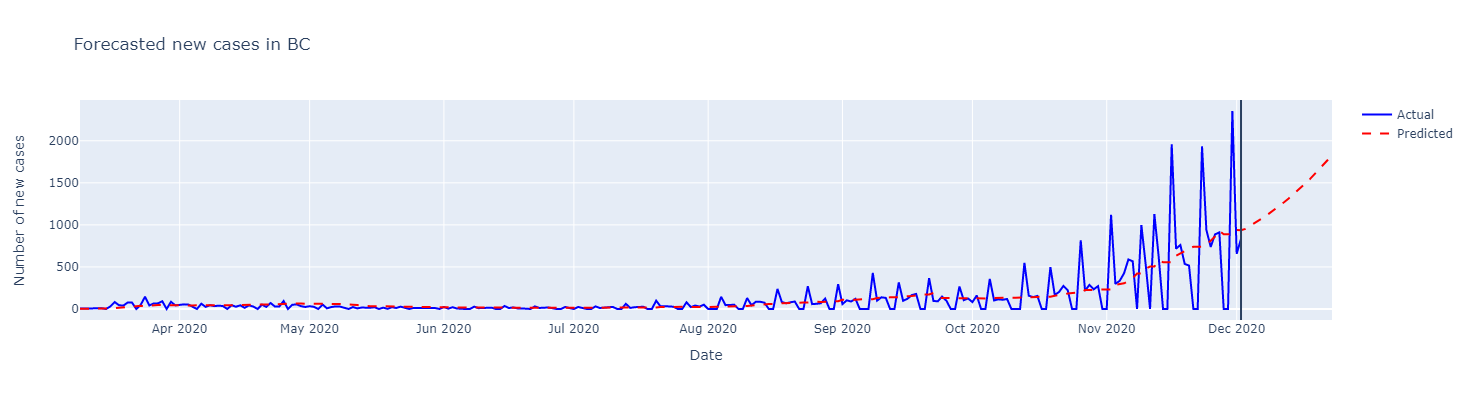

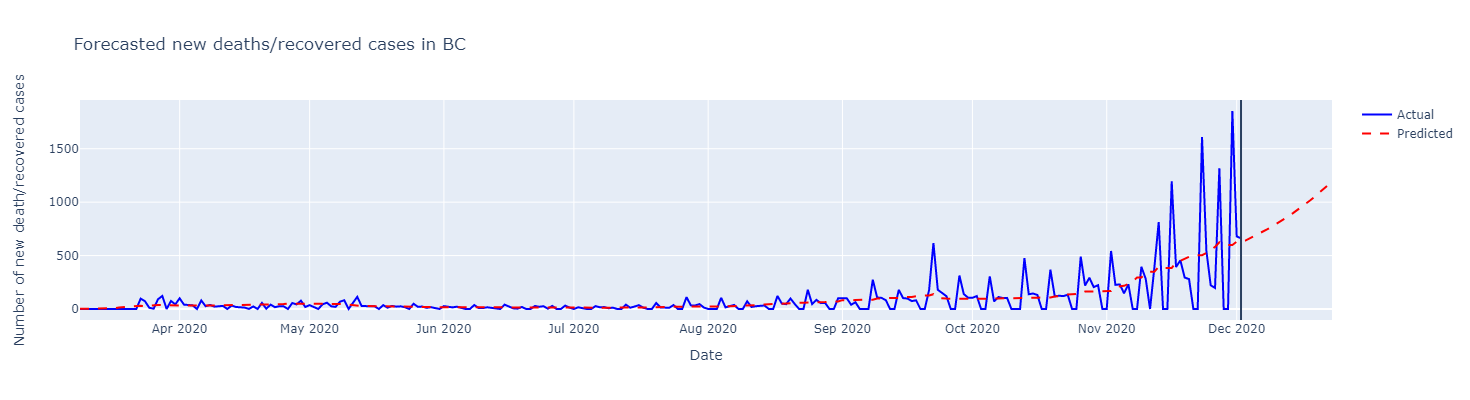

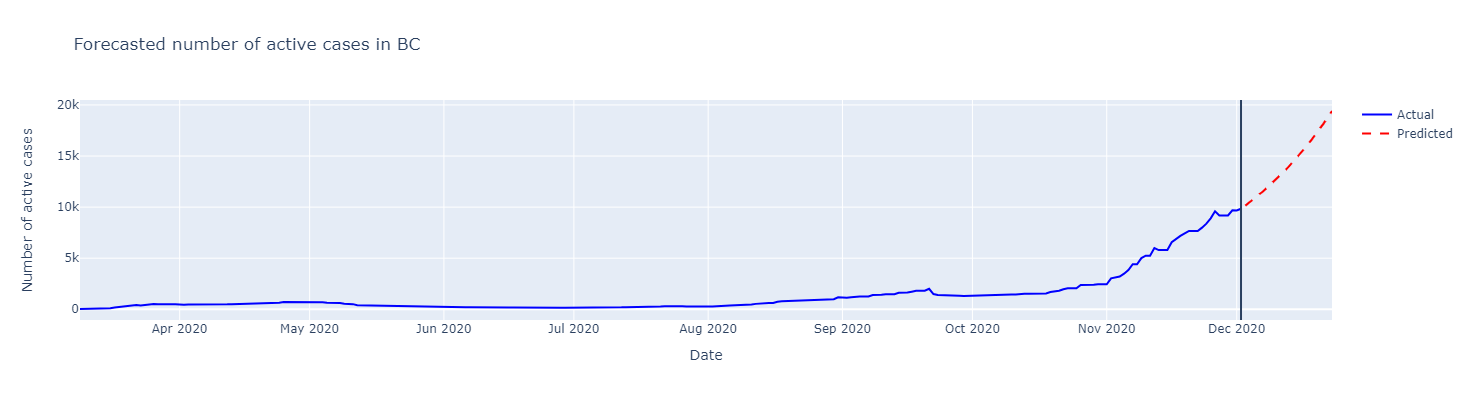

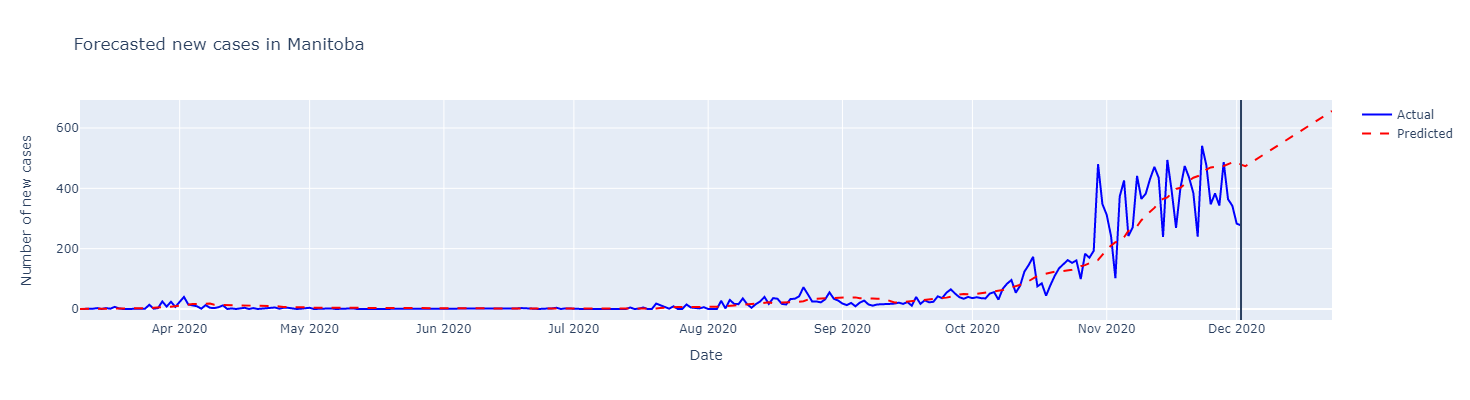

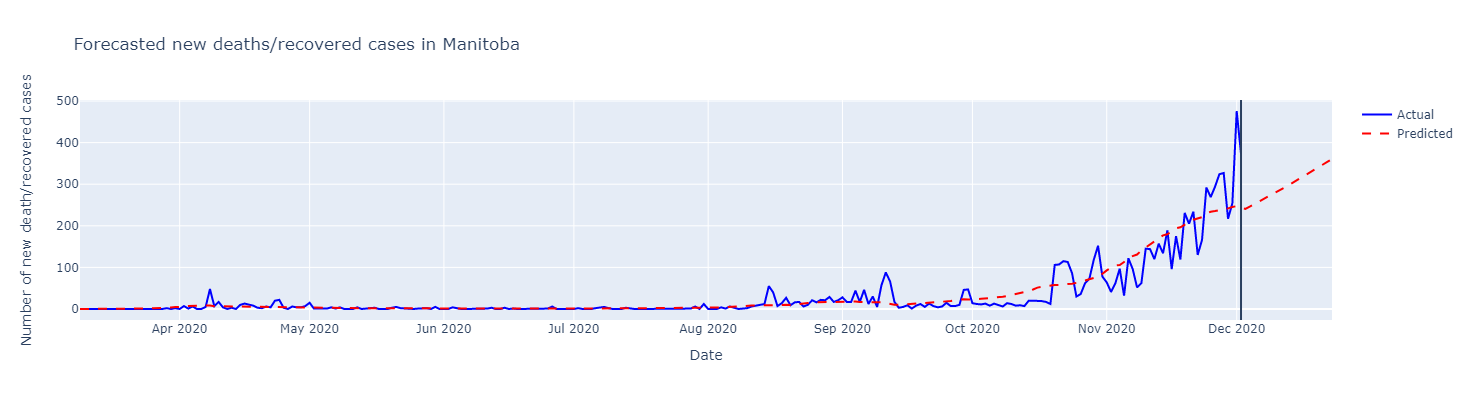

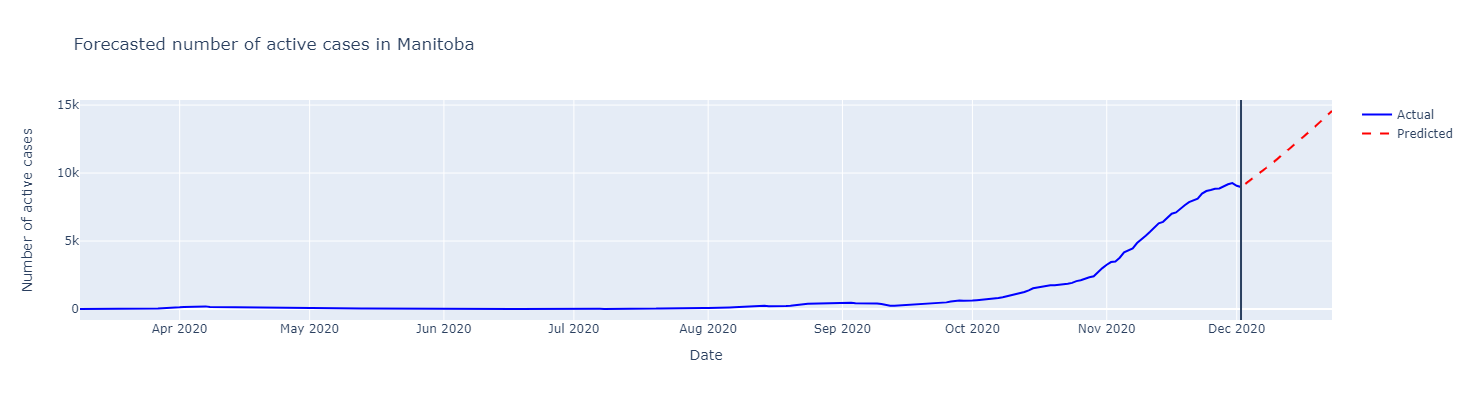

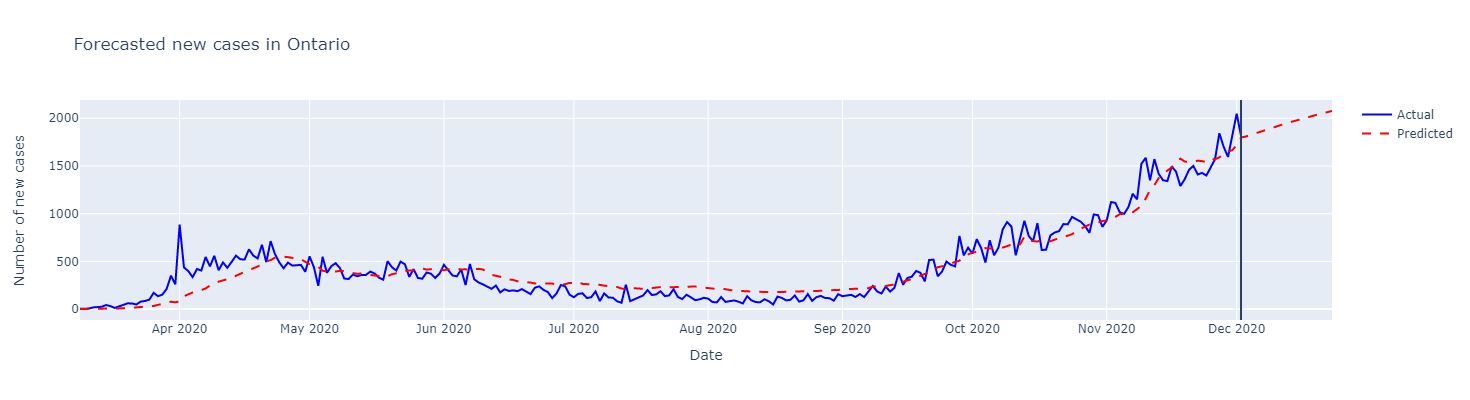

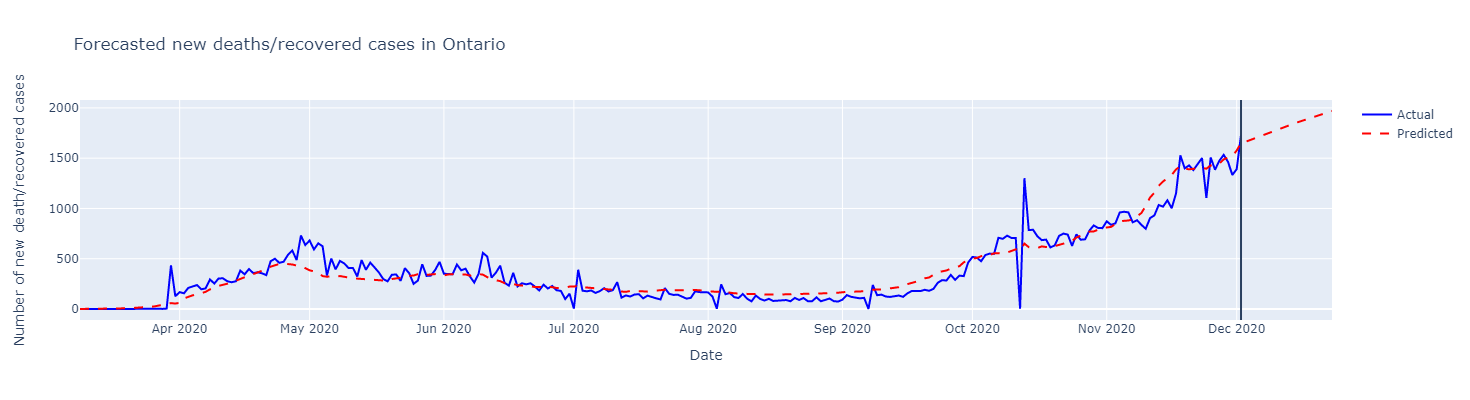

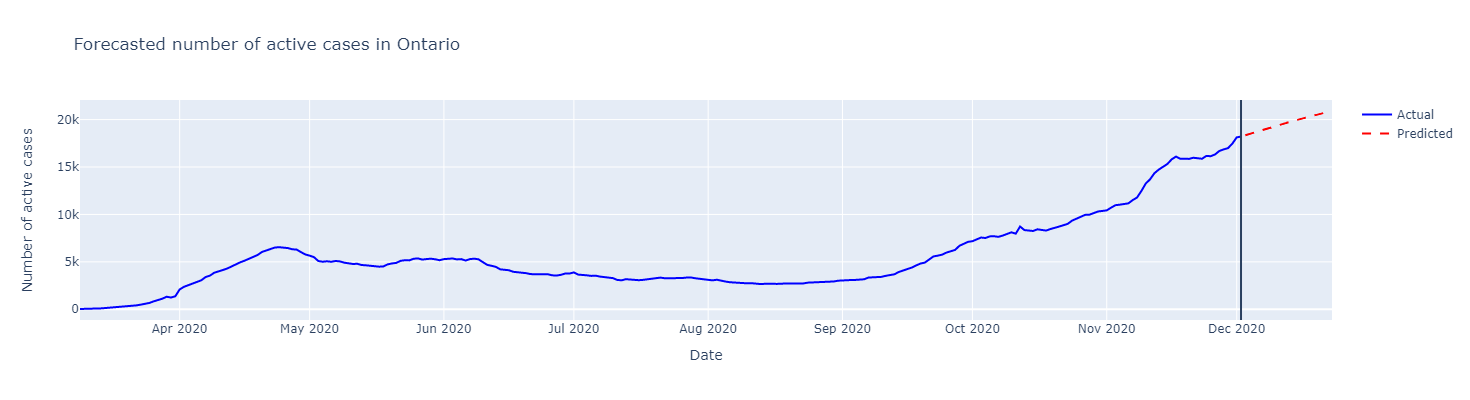

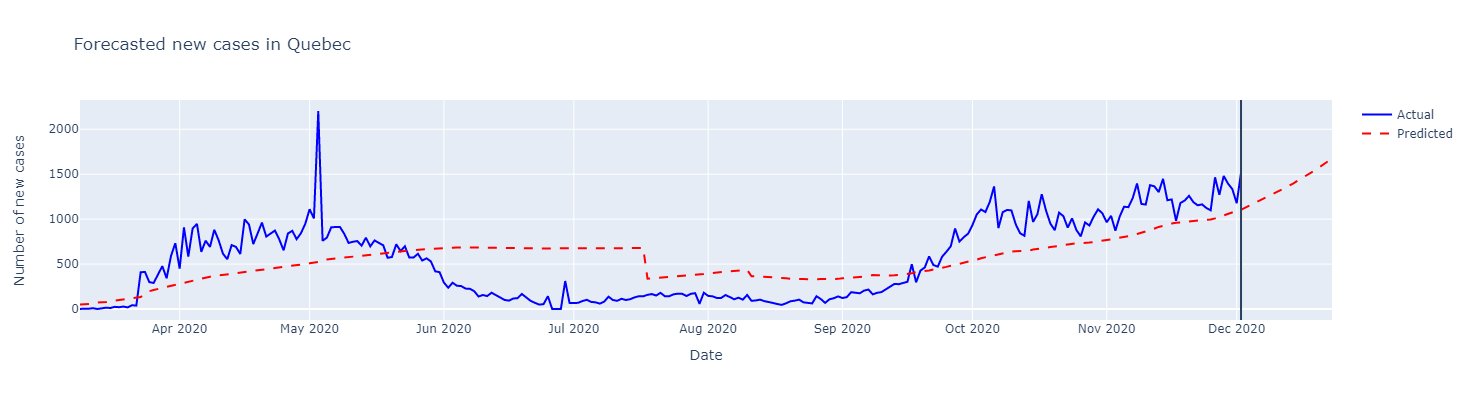

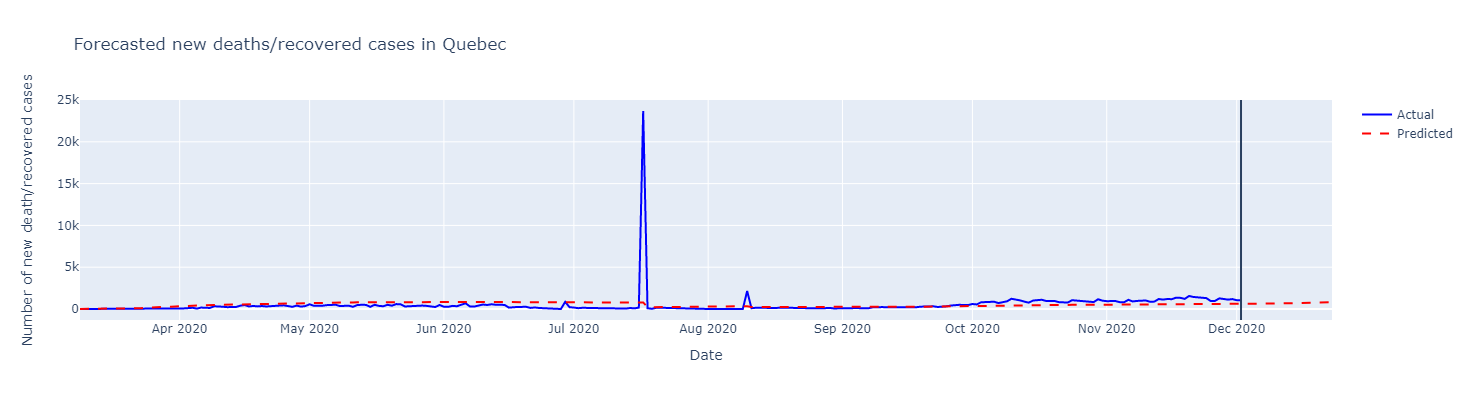

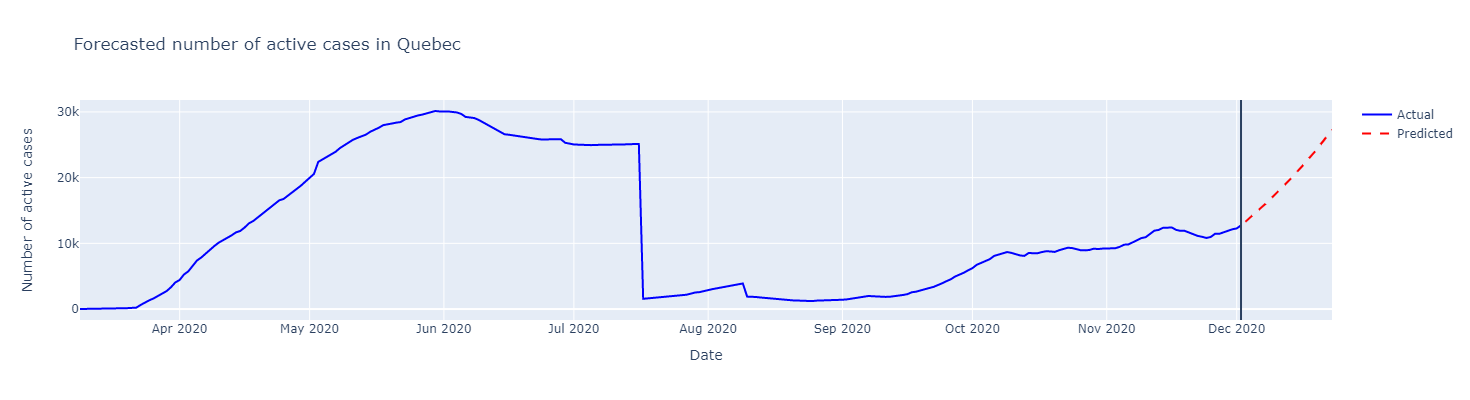

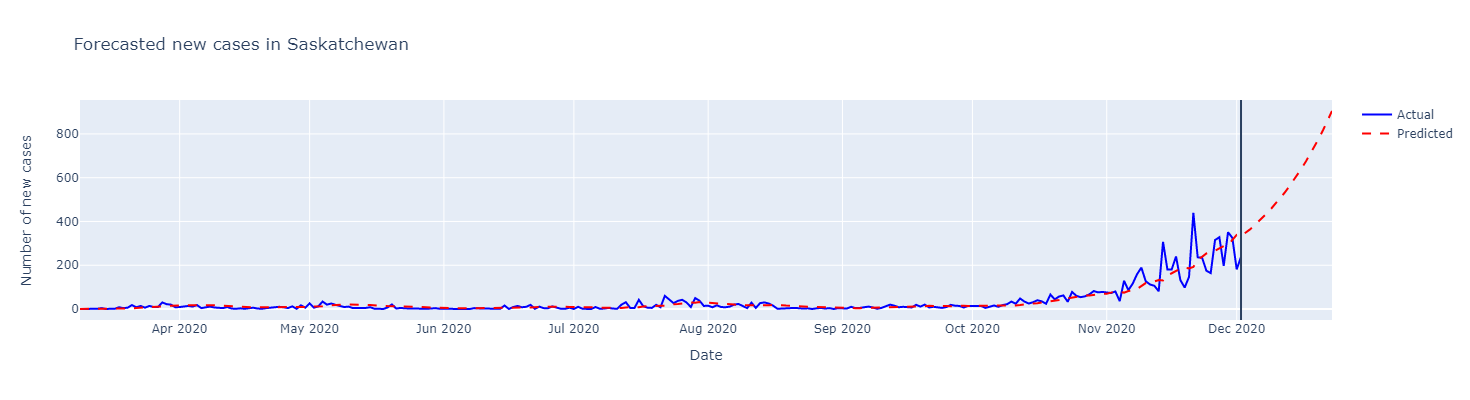

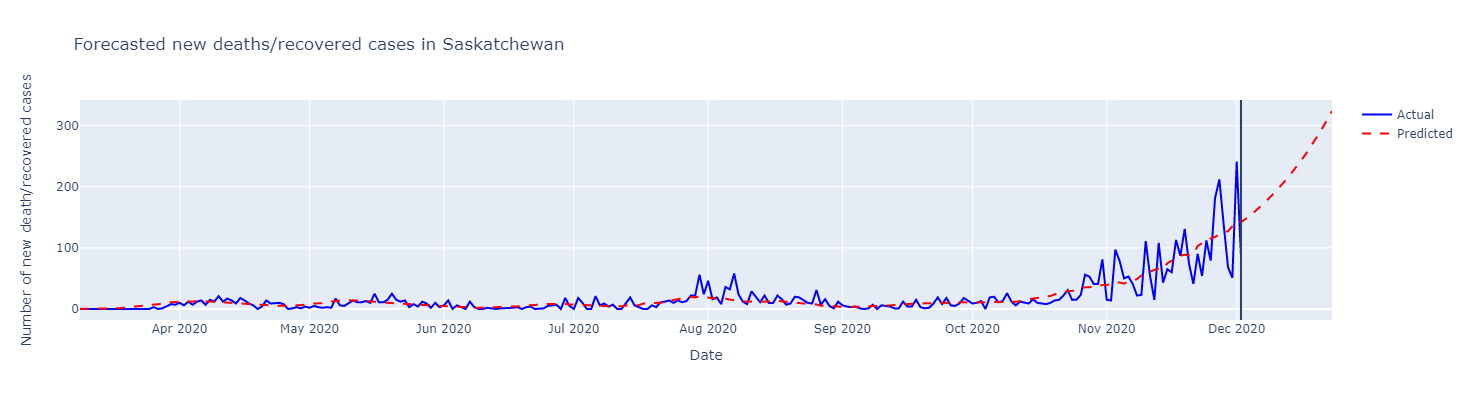

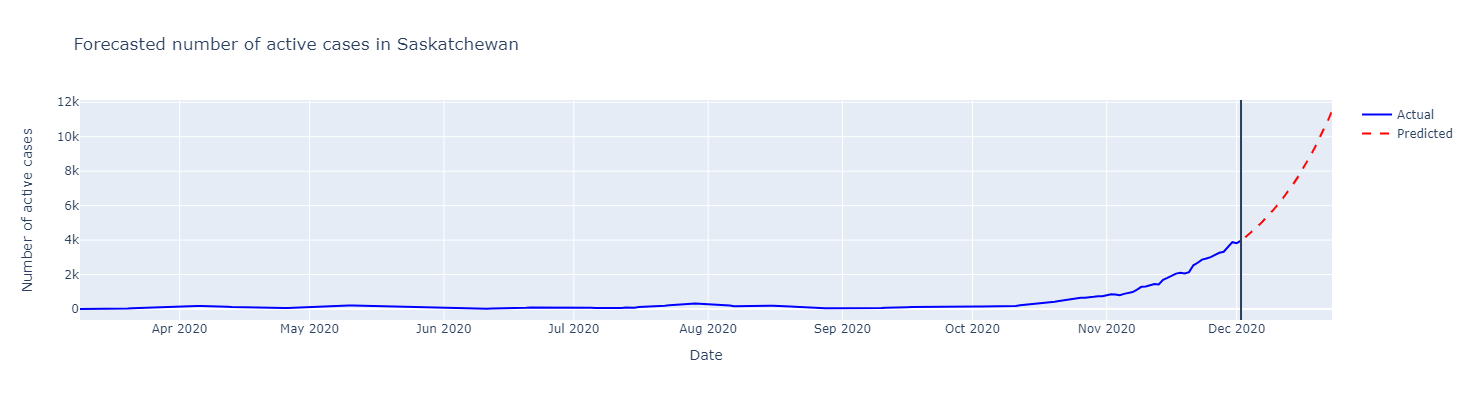

In [95]:
# Prediction plots for all provinces
for province in provinces:
    province_forecasts = forecasts.query('province == @province')
    
    plot_predictions(province_forecasts,
                     y = 'cases',
                     y_label = 'Number of new cases',
                     title = f'Forecasted new cases in {province}',
                     include_ci = False)

    plot_predictions(province_forecasts,
                     y = 'removed',
                     y_label = 'Number of new death/recovered cases',
                     title = f'Forecasted new deaths/recovered cases in {province}',
                     include_ci = False)
    
    plot_predictions(province_forecasts,
                     y = 'active_cases',
                     y_label = 'Number of active cases',
                     title = f'Forecasted number of active cases in {province}')

### Comments
- Overall the forecasts and fitted curves seem to fit the actual data well. Though for some provinces it seems like the forecasts are too high for active cases and new removed cases
- For quebec there's huge drop in predicted cases on July 18 most likely caused from the huge drop in active cases in Quebec. The noise in the data is effecting the performance of the model too much

## Poisson regression Combined Model

Similar to the above model. The combined poisson regression model has all province temporal variables as predictors. For example, for Ontario we use previous day information for Ontario as well as Alberta, BC, Manitoba, etc in order to predict the next day new cases and new removed. For Ontario for example, we model the new cases as 

$$
Y_t \sim Poisson(\mu_t) \\
log(\mu_t) = \beta_{1t} + \beta_{2t}log(I_{BC, t-1} + 1) + \alpha_tlog(S_{BC, t-1}/N) + \beta_{2t}log(I_{QC, t-1} + 1) + \alpha_tlog(S_{QC, t-1}/N) + ...
$$

and the model for new removed cases as

$$
\Delta D_t \sim Poisson({\mu_t}^D) \\
log({\mu_t}^D) = \beta_{1t}^D + \beta_{2t}^D log(I_{BC, t-1} + 1) + \beta_{2t}^D log(I_{QC, t-1} + 1) + ...
$$

For the variables corresponding to all other provinces than current one in model we also place higher regularization on those parameters so the variables relating to the given province have higher effect.

In [96]:
# Preprocess data
active_cases_provinces_preprocessed = preprocess_data(active_cases_provinces, add_province_columns=True, drop_first_day=True)
X = active_cases_provinces_preprocessed
Y = active_cases_provinces_preprocessed[['province', 'date', 'cases', 'removed']]

In [97]:
# Fit model
model = StemPoissonRegressorCombined(lam_main=0.6, lam_other=100)
model.fit(X, Y)

In [98]:
# Get 3 week forecasts
forecasts = model.forecast(h=21)
forecasts = forecasts.merge(active_cases_provinces, how='left', on=['province', 'date'])

forecasts.tail(10)

province        date  active_cases_pred   cases_pred  removed_pred  \
1730      Manitoba  2020-12-22        8967.727475   399.915006    400.106101   
1731       Ontario  2020-12-22       18121.721741  1703.855570   1710.866626   
1732        Quebec  2020-12-22       12451.921641  1517.120757   1539.636618   
1733  Saskatchewan  2020-12-22        3969.847257   333.572238    333.584488   
1734       Alberta  2020-12-23       17145.513063  1616.121357   1616.004423   
1735            BC  2020-12-23        9835.770597   881.879978    881.814672   
1736      Manitoba  2020-12-23        8967.528193   399.973120    400.172402   
1737       Ontario  2020-12-23       18114.437791  1701.878371   1709.162320   
1738        Quebec  2020-12-23       12428.574125  1514.484887   1537.832403   
1739  Saskatchewan  2020-12-23        3969.834513   333.618258    333.631003   

     is_forecast  cumulative_cases  cumulative_recovered  cumulative_deaths  \
1730        True               NaN                   NaN                NaN   
1731        True               NaN                   NaN                NaN   
1732        True               NaN                   NaN                NaN   
1733        True               NaN                   NaN                NaN   
1734        True               NaN                   NaN                NaN   
1735        True               NaN                   NaN                NaN   
1736        True               NaN                   NaN                NaN   
1737        True               NaN                   NaN                NaN   
1738        True               NaN                   NaN                NaN   
1739        True               NaN                   NaN                NaN   

      active_cases  active_cases_change  deaths  recovered  cases  population  \
1730           NaN                  NaN     NaN        NaN    NaN         NaN   
1731           NaN                  NaN     NaN        NaN    NaN         NaN   
1732           NaN                  NaN     NaN        NaN    NaN         NaN   
1733           NaN                  NaN     NaN        NaN    NaN         NaN   
1734           NaN                  NaN     NaN        NaN    NaN         NaN   
1735           NaN                  NaN     NaN        NaN    NaN         NaN   
1736           NaN                  NaN     NaN        NaN    NaN         NaN   
1737           NaN                  NaN     NaN        NaN    NaN         NaN   
1738           NaN                  NaN     NaN        NaN    NaN         NaN   
1739           NaN                  NaN     NaN        NaN    NaN         NaN   

      removed  susceptible  percent_susceptible  
1730      NaN          NaN                  NaN  
1731      NaN          NaN                  NaN  
1732      NaN          NaN                  NaN  
1733      NaN          NaN                  NaN  
1734      NaN          NaN                  NaN  
1735      NaN          NaN                  NaN  
1736      NaN          NaN                  NaN  
1737      NaN          NaN                  NaN  
1738      NaN          NaN                  NaN  
1739      NaN          NaN                  NaN

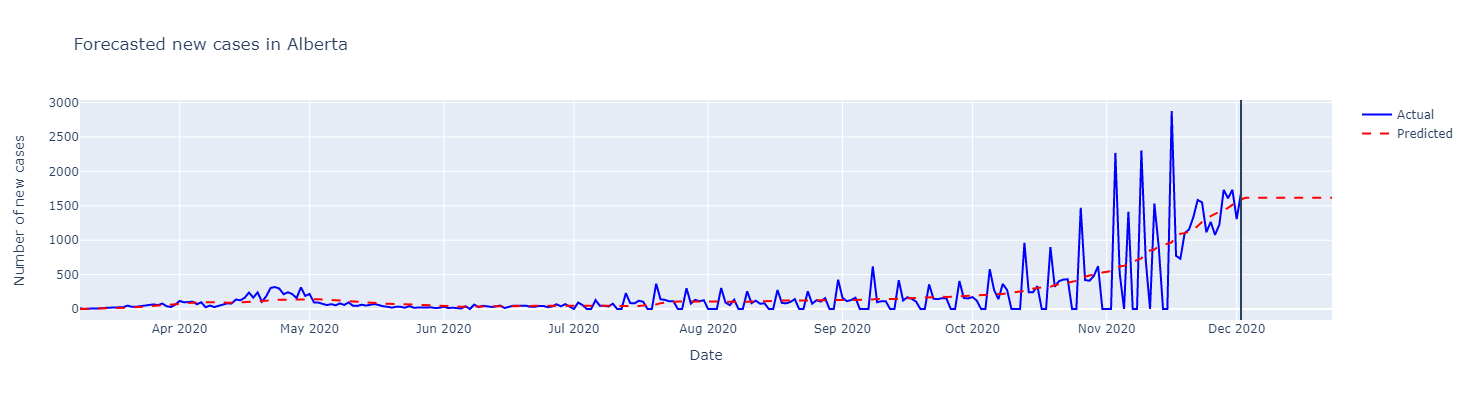

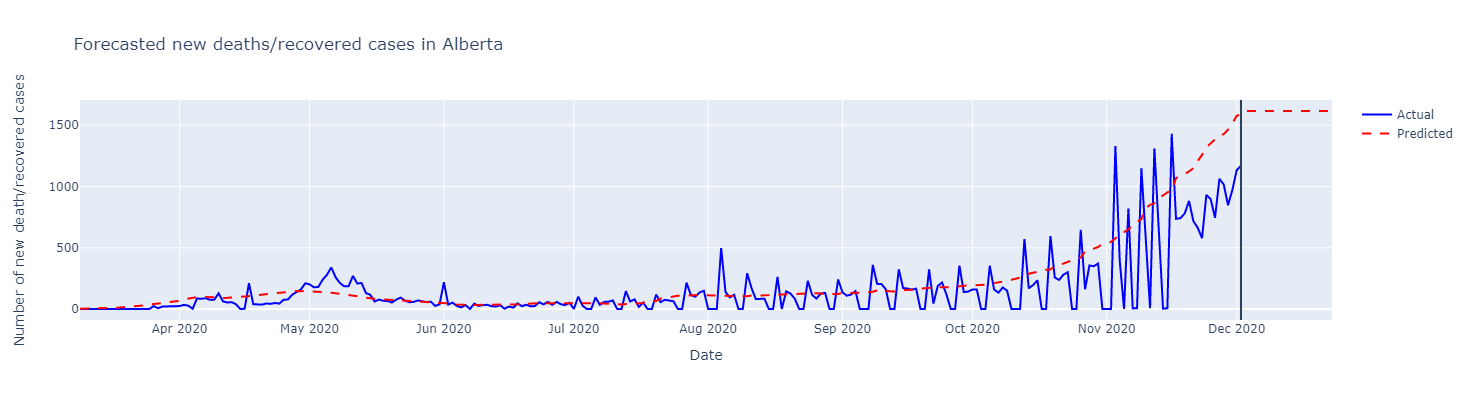

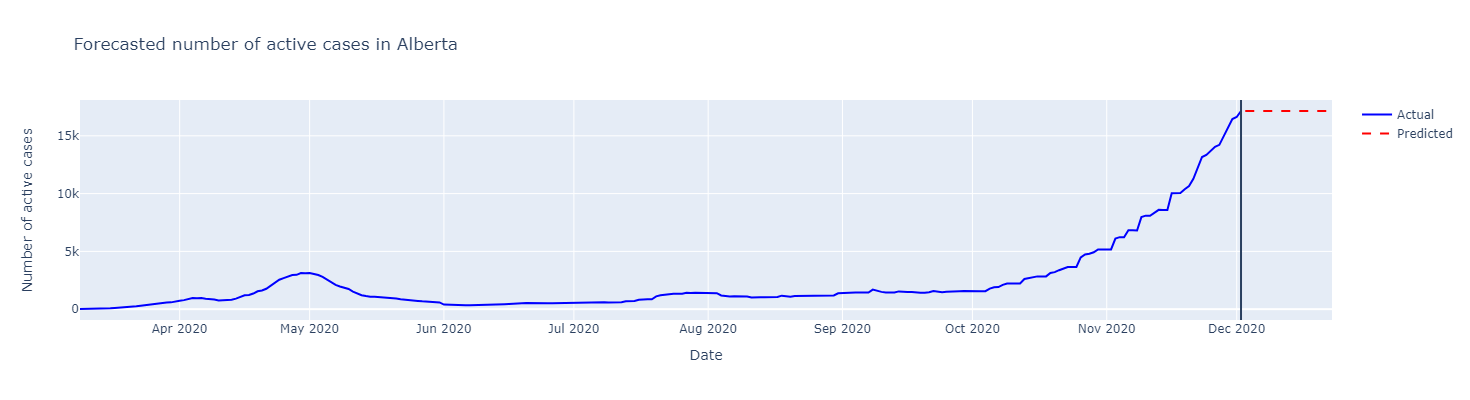

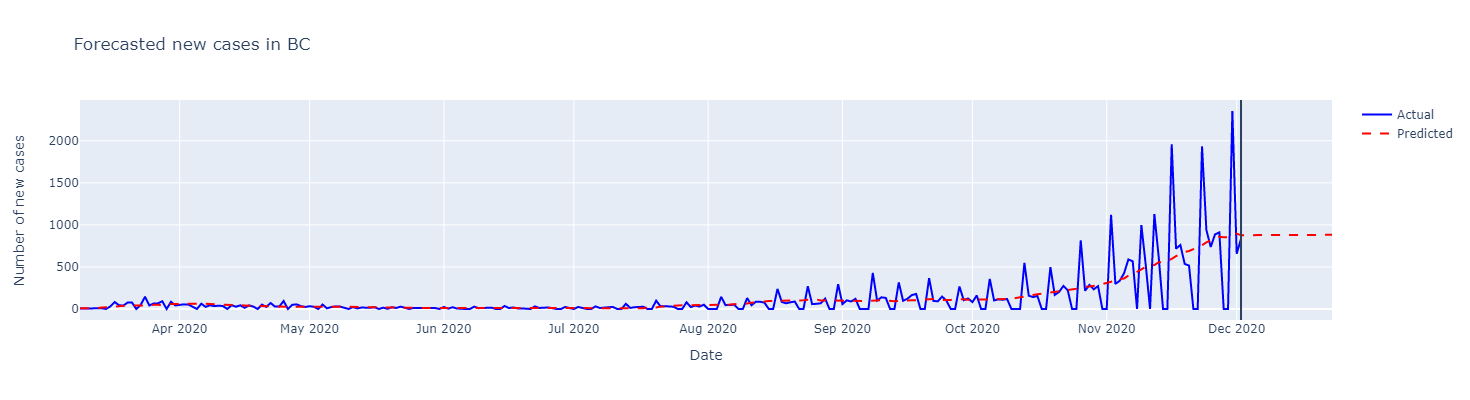

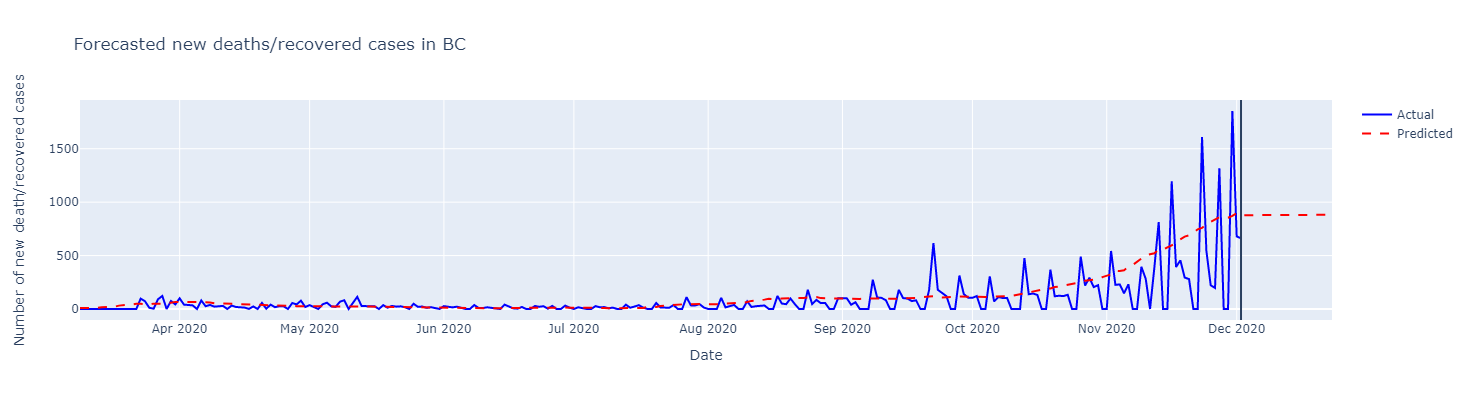

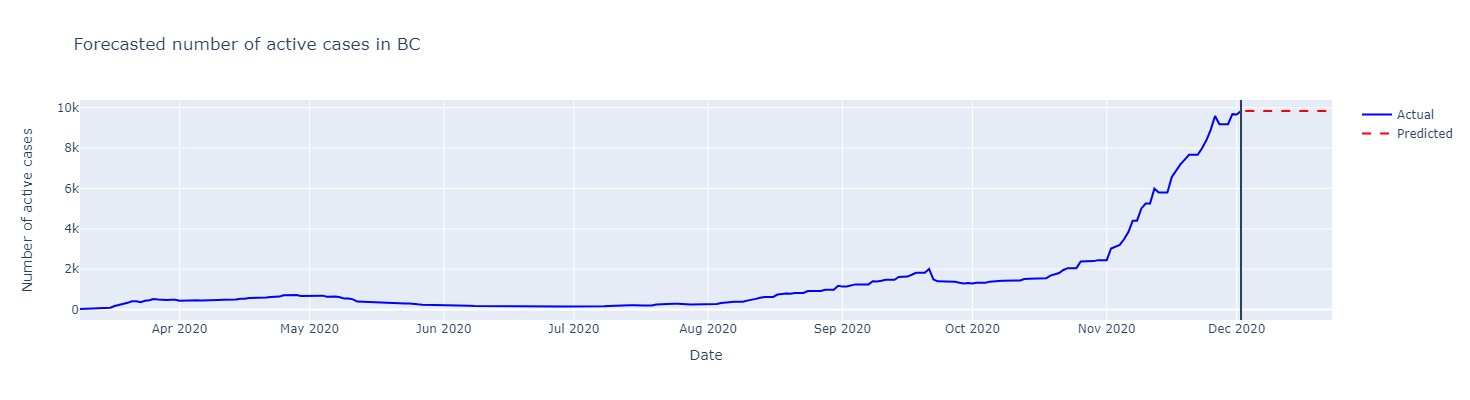

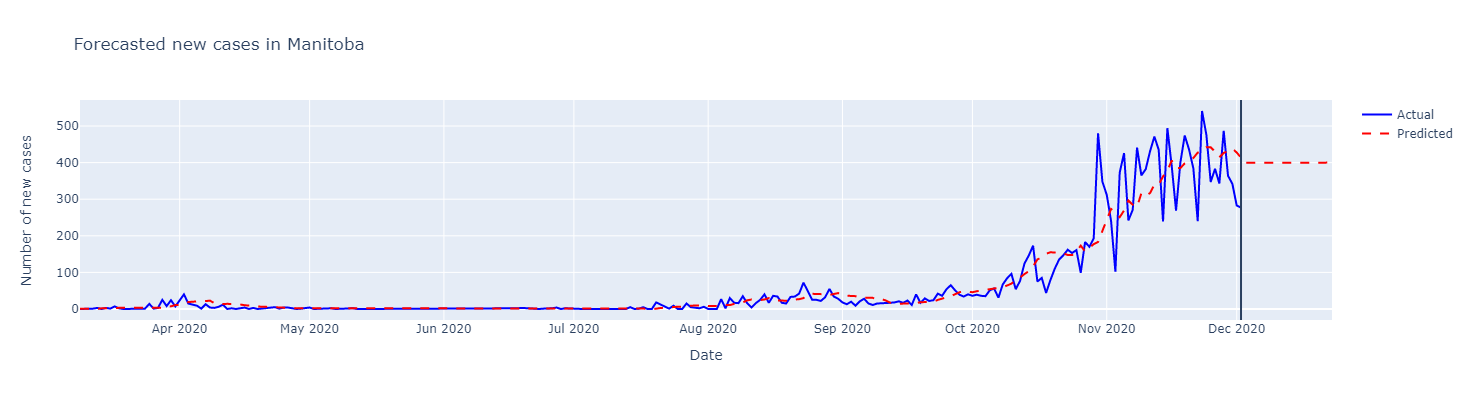

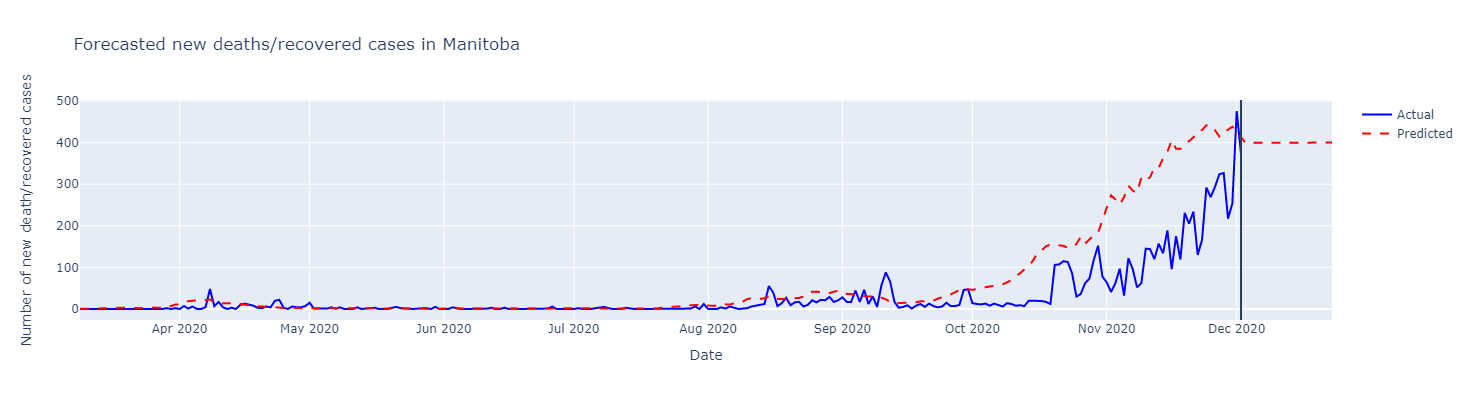

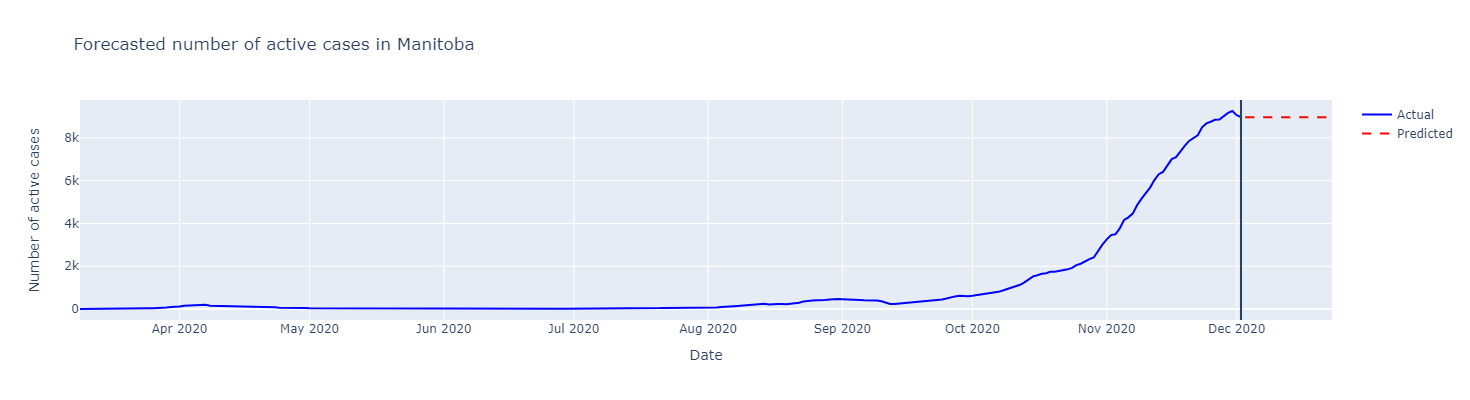

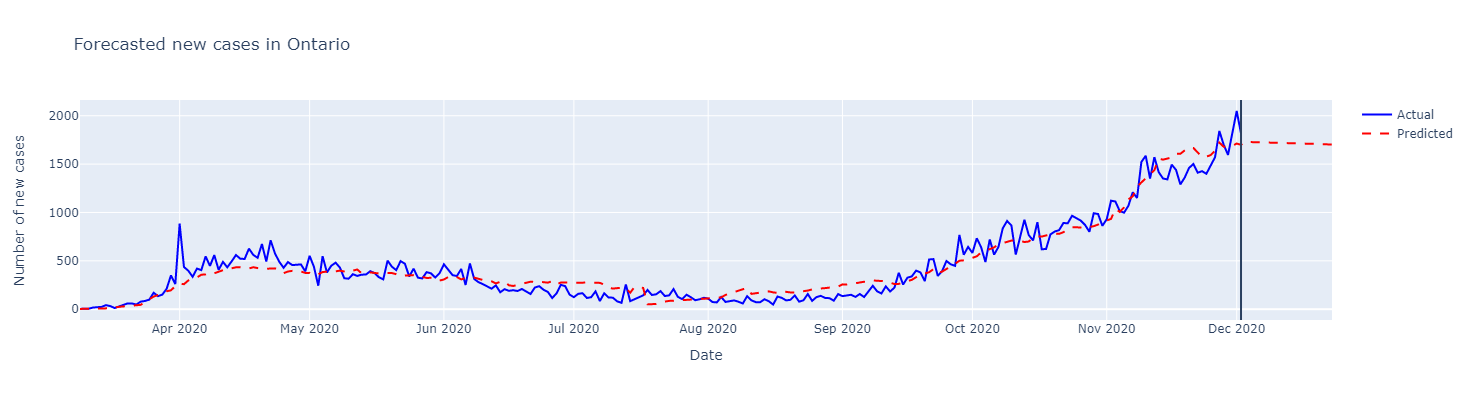

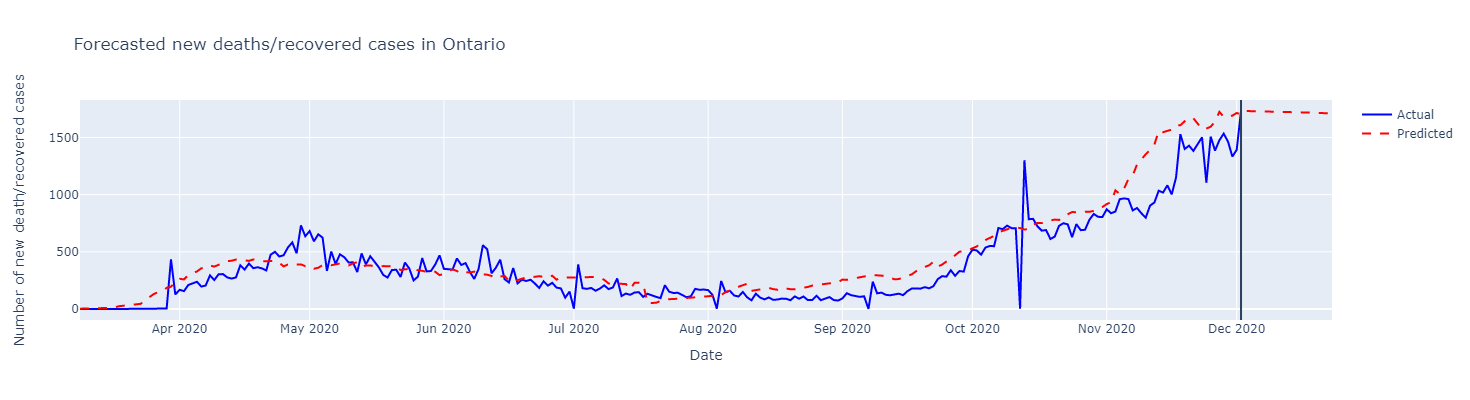

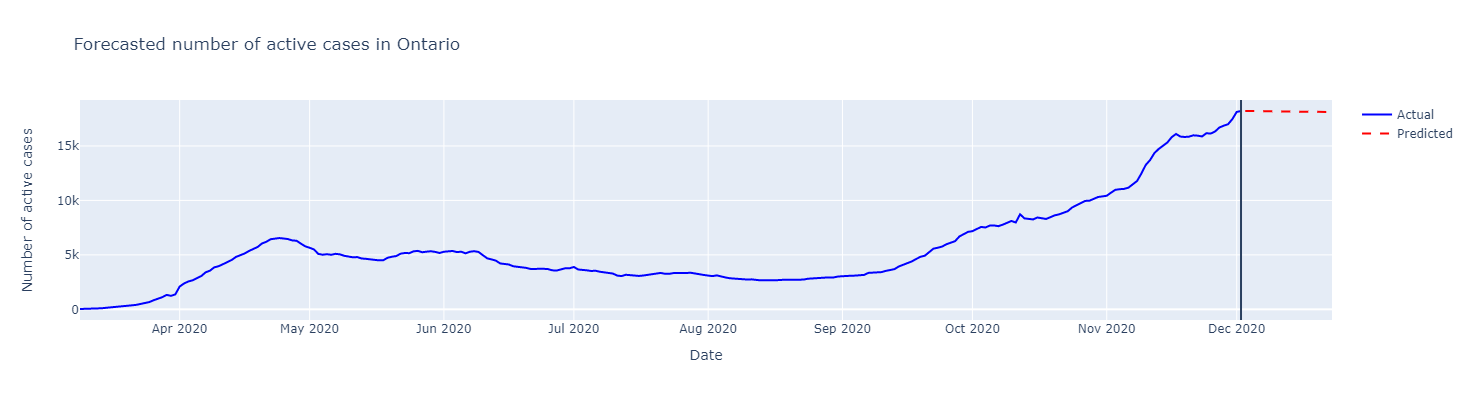

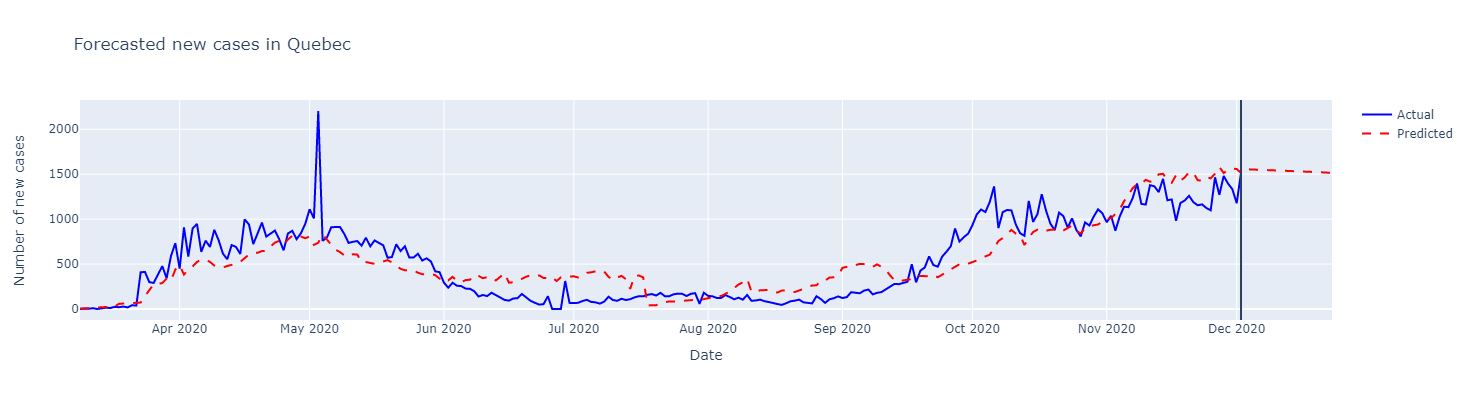

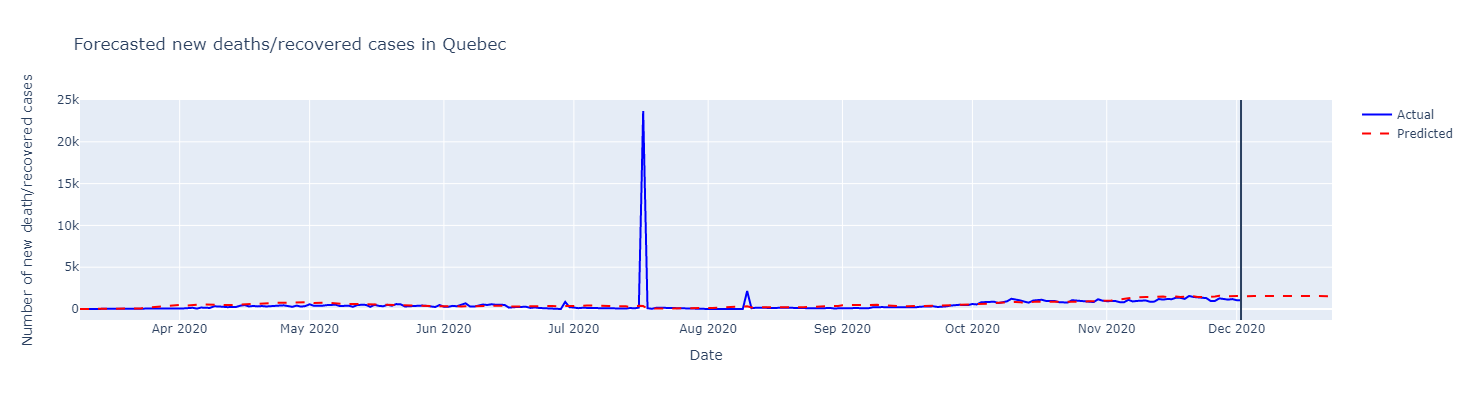

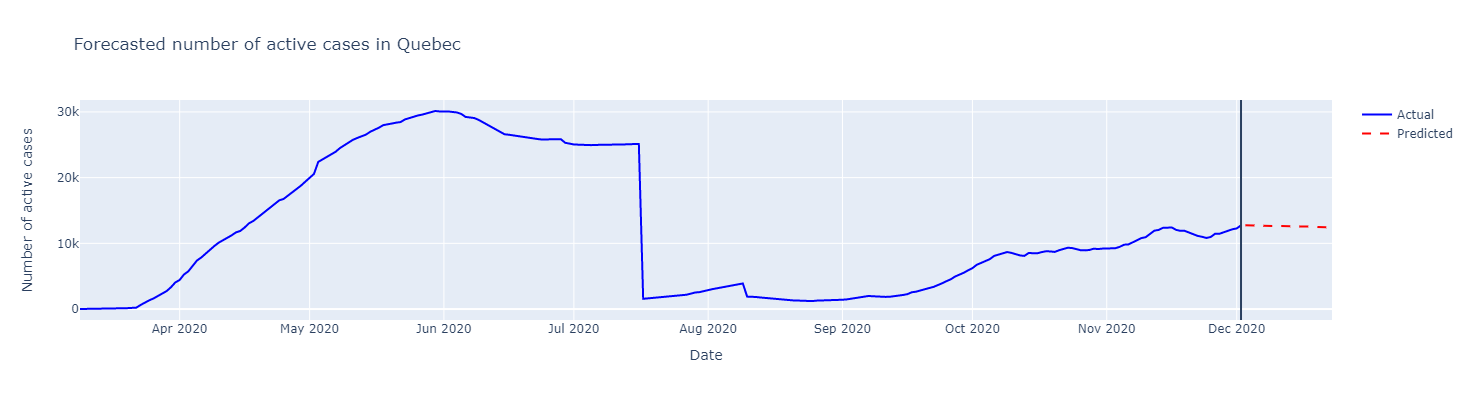

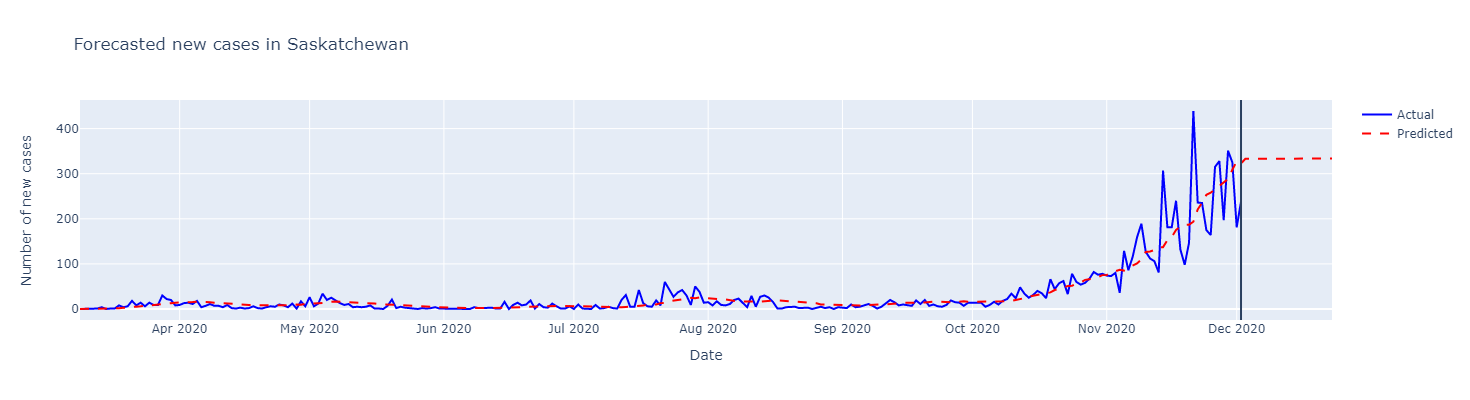

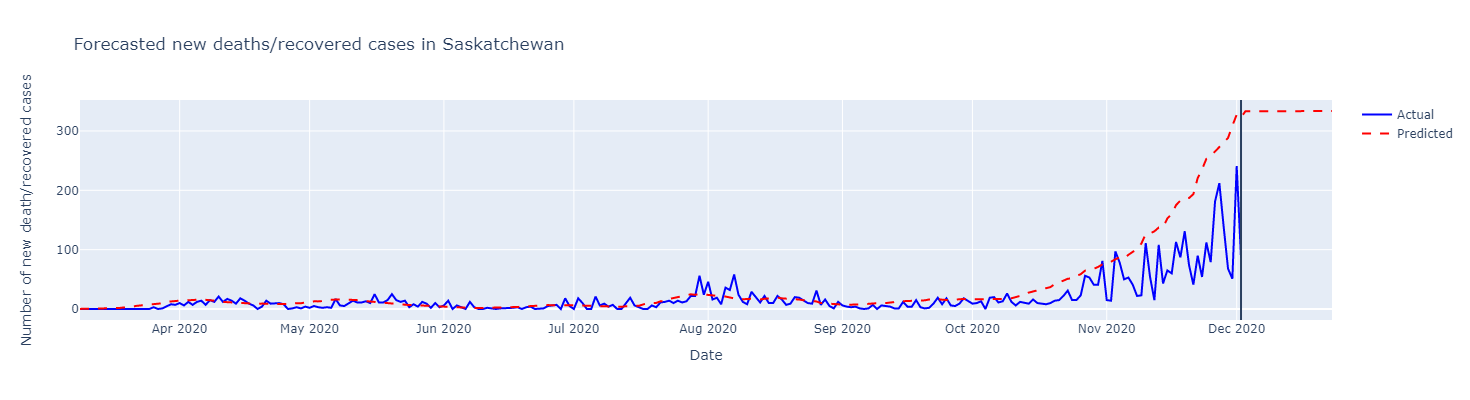

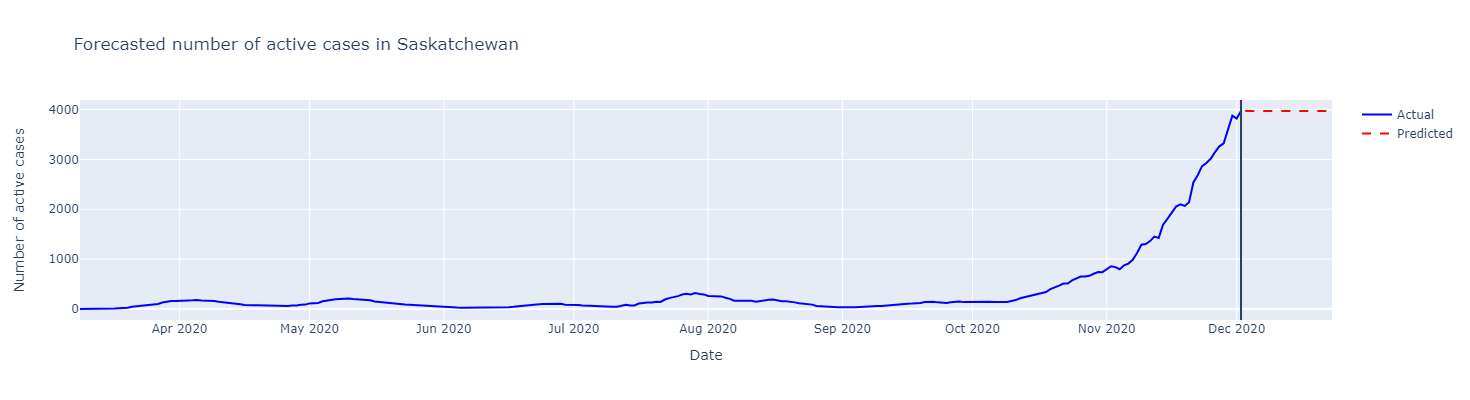

In [99]:
# Prediction plots for all provinces
provinces = active_cases_provinces['province'].unique()
for province in provinces:
    province_forecasts = forecasts.query('province == @province')
    
    plot_predictions(province_forecasts,
                     y = 'cases',
                     y_label = 'Number of new cases',
                     title = f'Forecasted new cases in {province}',
                     include_ci = False)

    plot_predictions(province_forecasts,
                     y = 'removed',
                     y_label = 'Number of new death/recovered cases',
                     title = f'Forecasted new deaths/recovered cases in {province}',
                     include_ci = False)
    
    plot_predictions(province_forecasts,
                     y = 'active_cases',
                     y_label = 'Number of active cases',
                     title = f'Forecasted number of active cases in {province}')

### Comments
- Compared to the single model case these ones give very flat forecasts
- Coefficients for all provinces for a given model are significant and their magnitude is just as large as the coefficient for the given province. This could be that the province data follow similar patterns, not linearly independent data, which can explain these results

## Cross validation

In [100]:
# Dataframe to store cross validation scores
cv_scores = pd.DataFrame(columns=["province", "method", "fold", "rmse"])

### Poisson regression

In [109]:
# Preprocess all province data
active_cases_provinces_preprocessed = preprocess_data(active_cases_provinces, drop_first_day=True)
X = active_cases_provinces_preprocessed
Y = active_cases_provinces_preprocessed[['province', 'date', 'cases', 'removed']]

In [117]:
%%time

tscv = TimeSeriesSplit(n_splits=10)

# loop through each province and each split
for province in provinces:
    province_data = active_cases_provinces_preprocessed.query('province == @province')
    
    for index, (train_index, test_index) in enumerate(tscv.split(province_data)):
        # Split data into train and test
        data_train = province_data.iloc[train_index]
        data_test = province_data.iloc[test_index]
        X_train, Y_train = data_train, data_train[['province', 'date', 'cases', 'removed']]
        Y_test = data_test[['province', 'date', 'cases', 'removed']]

        # Fit model to train set
        model = StemPoissonRegressor()
        model.fit(X, Y)        

        # Calculate test fold rmse for both cases and removed
        province_forecasts = model.forecast(h = test_index.shape[0]).iloc[test_index]
        cases_rmse = mean_squared_error(province_forecasts['cases_pred'], Y_test['cases'], squared=False)
        removed_rmse = mean_squared_error(province_forecasts['removed_pred'], Y_test['removed'], squared=False)

        # Append results
        cv_scores = cv_scores.append({'province': province, 'method': 'poisson_reg_linear', 'response': 'cases', 'fold': index, 'rmse': cases_rmse}, ignore_index=True)
        cv_scores = cv_scores.append({'province': province, 'method': 'poisson_reg_linear', 'response': 'removed', 'fold': index, 'rmse': removed_rmse}, ignore_index=True)        

Wall time: 14 s


In [118]:
# Average rmse scores
cv_scores.query('method == "poisson_reg_linear"').groupby(["province", 'response']).agg(
    {"rmse": ["mean", "std", "min", "max"]}
).reset_index()

province response        rmse                                     
                                 mean          std        min          max
0        Alberta    cases  213.369526   241.473494  44.195126   739.318689
1        Alberta  removed  137.088980   128.212500  28.732075   414.402717
2             BC    cases  176.542569   181.044169  60.164332   660.826240
3             BC  removed  135.076391   139.071296  32.840853   504.325365
4       Manitoba    cases  161.433187   135.412436  69.440510   536.426828
5       Manitoba  removed  128.109514    91.283829  45.725227   352.117840
6        Ontario    cases  299.814729   230.837841  37.932290   704.097979
7        Ontario  removed  294.398851   227.486561  27.146688   727.192983
8         Quebec    cases  389.050336   307.263530  38.429693   755.982853
9         Quebec  removed  838.255024  1414.251243  97.774476  4821.404656
10  Saskatchewan    cases  191.357454   180.590064  67.774765   671.635224
11  Saskatchewan  removed  142.611836   130.508880  42.436997   477.984469

### Comparison of different models

In [119]:
# Save results
cv_scores.to_csv("../models/poisson_regression_val_scores.csv", index=False)

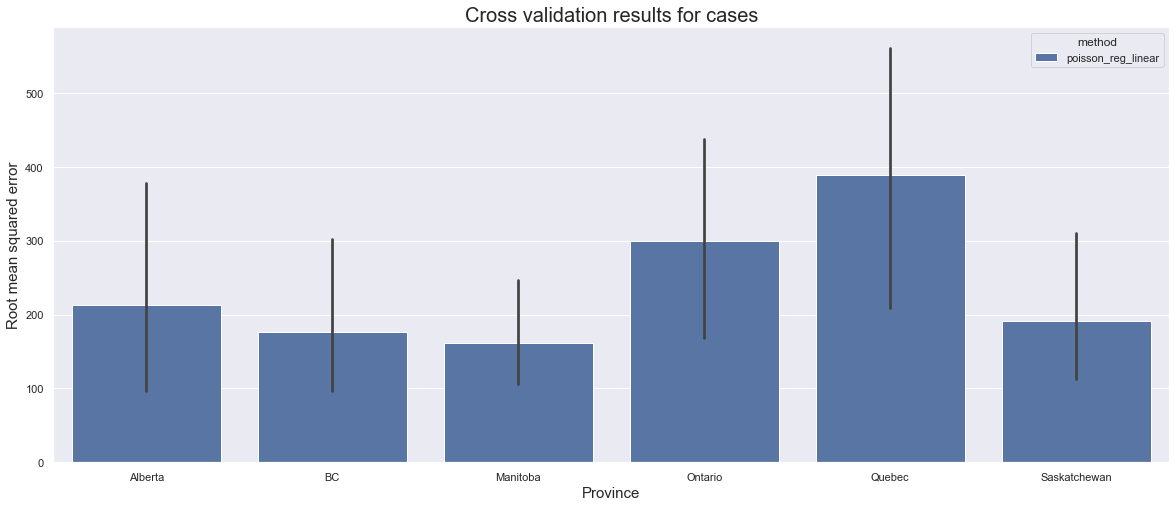

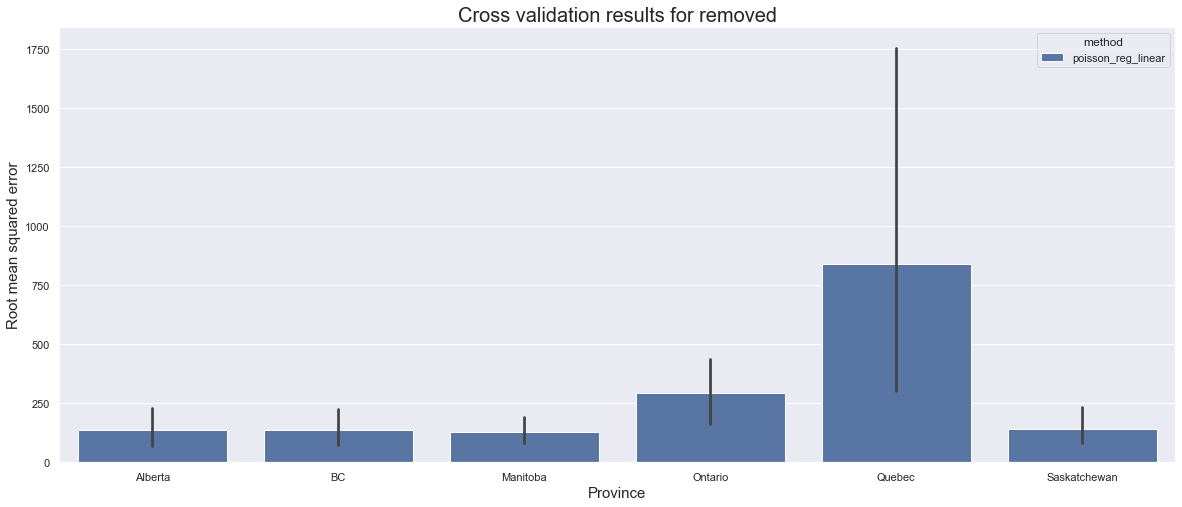

In [125]:
# Barplots for cross val scores across each province per method

fig = plt.figure(figsize=(20, 8))
ax = sns.barplot(x="province", y="rmse", hue="method", data=cv_scores.query('response == "cases"'))
t = ax.set_title("Cross validation results for cases", fontsize=20)
t = ax.set_ylabel("Root mean squared error", fontsize=15)
t = ax.set_xlabel("Province", fontsize=15)

fig = plt.figure(figsize=(20, 8))
ax = sns.barplot(x="province", y="rmse", hue="method", data=cv_scores.query('response == "removed"'))
t = ax.set_title("Cross validation results for removed", fontsize=20)
t = ax.set_ylabel("Root mean squared error", fontsize=15)
t = ax.set_xlabel("Province", fontsize=15)

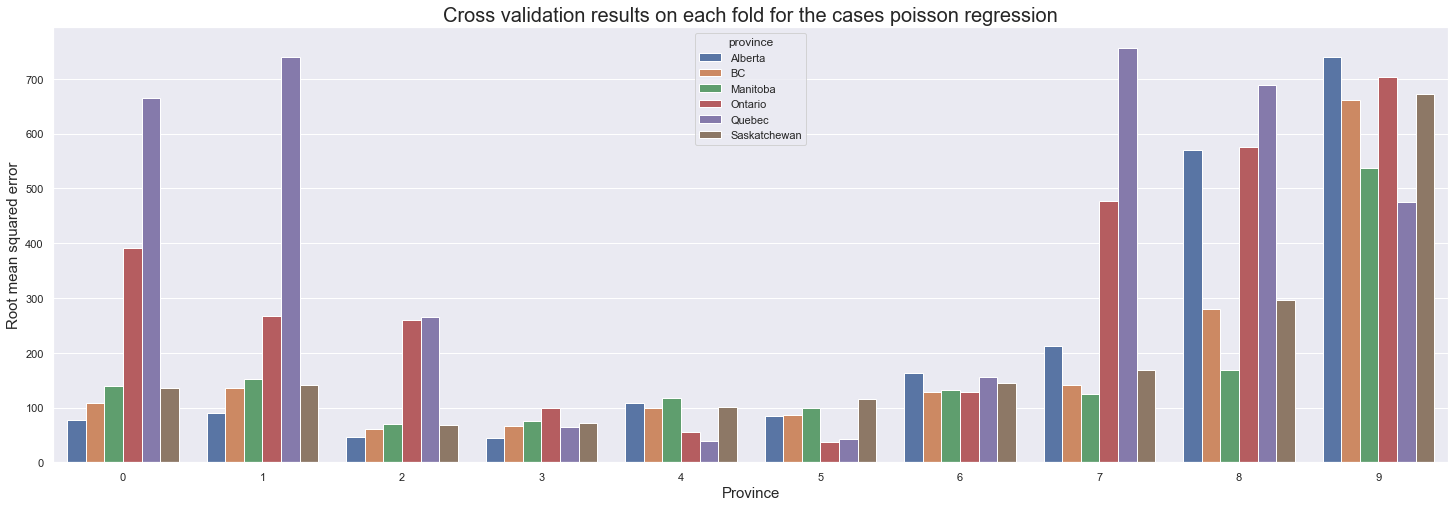

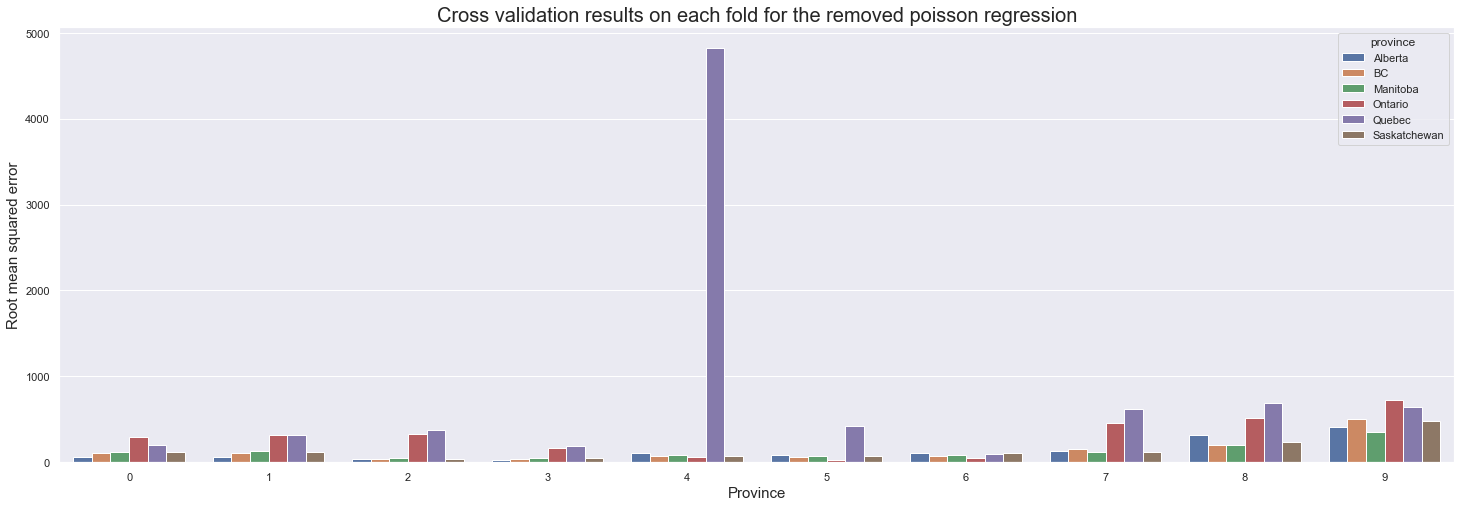

In [128]:
# Individual k fold scores

fig = plt.figure(figsize=(25, 8))
ax = sns.barplot(
    x="fold", y="rmse", hue="province", data=cv_scores.query('method == "poisson_reg_linear" and response == "cases"')
)
t = ax.set_title("Cross validation results on each fold for the cases poisson regression", fontsize=20)
t = ax.set_ylabel("Root mean squared error", fontsize=15)
t = ax.set_xlabel("Province", fontsize=15)

fig = plt.figure(figsize=(25, 8))
ax = sns.barplot(
    x="fold", y="rmse", hue="province", data=cv_scores.query('method == "poisson_reg_linear" and response == "removed"')
)
t = ax.set_title("Cross validation results on each fold for the removed poisson regression", fontsize=20)
t = ax.set_ylabel("Root mean squared error", fontsize=15)
t = ax.set_xlabel("Province", fontsize=15)

### Comments

- Overall the results are pretty bad for each province and rmse is much too high. Looking at the k fold test scores it seems like the fold rmse is higher near the start which makes sense as there is not much data to train on, but also near the end as the government interventions changed and there was an increase in cases
- Currently the linear poisson regression model seems too simple and makes large errors due to not being able to account for government intervention